In [ ]:
try:
    from pyDOE import lhs
except:
    _=!pip install pyDOE
    from pyDOE import lhs

try:
    import GPy
except:
    _=!pip install GPy
    import GPy
from GP_Bayesian_inference_double import DoJobs

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from theano import function, shared, tensor as tt

In [ ]:
# generate initial training dataset
def GenerateSample(num_simulations,bounds):
    # Specify how many simulations you can afford:
    X_scaled = lhs(1, num_simulations)

    # Let's get to the original space
    X_sampled = X_scaled * (bounds[1] - bounds[0]) + bounds[0]
    X_sampled = X_sampled[:,0]
    X_sampled.sort()  
    return X_sampled

def RunFunction(xx):
  x1 = xx[:,0]
  x2 = xx[:,1]
  # Branin function
  return (-1.275/np.pi**2 * x1**2 + 5./np.pi * x1 + x2 - 6.)**2 \
        +(10. - 5./4./np.pi) * np.cos(x1) + 10.

def RunFunction1(xx):
    return 0.5*np.exp(xx) + 0.05 * np.sin(3.*np.pi*xx)

def RunFunction2(xx):
    return .5*np.exp(-xx) + 0.05 * np.cos(-3.*np.pi*xx)

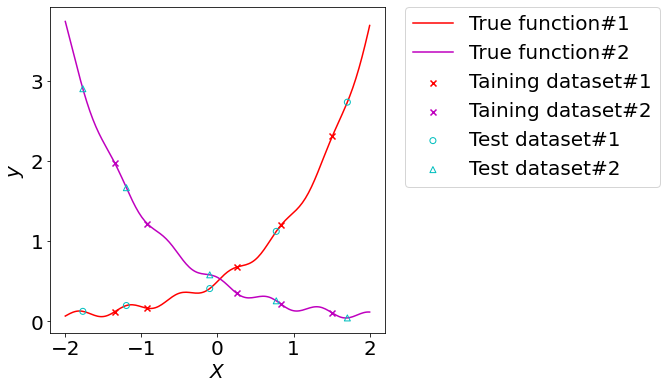

In [ ]:
dims = 2
num_sim = 5
data_x = np.loadtxt('test_data_%iD_T%i.txt'%(dims,num_sim))[:,0] # test data(observation)
Xtr = np.loadtxt('x_sampled_%iD_T%i.txt'%(dims,num_sim)) # training data

X_range = np.array([-2, 2])

if Xtr.ndim == 1:
    Xtr_m, Xtr_s = np.mean(Xtr), np.std(Xtr)
    Xtr_scaled = (Xtr - Xtr_m) / Xtr_s
else:
    Xtr_m, Xtr_s = np.mean(Xtr, axis=1), np.std(Xtr,axis=1)
    Xtr_scaled = (Xtr - Xtr_m[:,None]) / Xtr_s[:,None]

Ytr1 = RunFunction1(Xtr)
Ytr1_m, Ytr1_s = np.mean(Ytr1), np.std(Ytr1)
Ytr1_scaled = (Ytr1 - Ytr1_m) / Ytr1_s

Ytr2 = RunFunction2(Xtr)
Ytr2_m, Ytr2_s = np.mean(Ytr2), np.std(Ytr2)
Ytr2_scaled = (Ytr2 - Ytr2_m) / Ytr2_s

# test data(observation)
if Xtr.ndim == 1:
    data_x_scaled = (data_x - Xtr_m) / Xtr_s
else:
    data_x_scaled = (data_x - Xtr_m[:,None]) / Xtr_s[:,None]

data1 = RunFunction1(data_x)
data1_scaled = (data1 - Ytr1_m) / Ytr1_s

data2 = RunFunction2(data_x)
data2_scaled = (data2 - Ytr2_m) / Ytr2_s

# plotting points
xtest = np.linspace(X_range[0], X_range[1], 200)
if Xtr.ndim == 1:
    xtest_scaled = (xtest - Xtr_m) / Xtr_s
else:
    xtest_scaled = (xtest - Xtr_m[:,None]) / Xtr_s[:,None]

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(Xtr,Ytr1,color='r',marker='x',label='Taining dataset#1',zorder=2)
ax.scatter(Xtr,Ytr2,color='m',marker='x',label='Taining dataset#2',zorder=2)
ax.plot(xtest,RunFunction1(xtest),color='r',label='True function#1',zorder=1)
ax.plot(xtest,RunFunction2(xtest),color='m',label='True function#2',zorder=1)
ax.scatter(data_x,data1,color='c',marker='o', facecolors='none',label='Test dataset#1',zorder=3)
ax.scatter(data_x,data2,color='c',marker='^', facecolors='none',label='Test dataset#2',zorder=3)
ax.legend(frameon=True,bbox_to_anchor=(1.03,1.03),fontsize=20)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('$X$',fontsize=20)
ax.set_ylabel('$y$',fontsize=20)

fig.savefig('Example_%iD_T%i.pdf'%(dims,num_sim),dpi=300)
np.savetxt('true_data_%iD_T%i.txt'%(dims,num_sim), np.hstack([xtest[:,None],RunFunction1(xtest)[:,None],RunFunction2(xtest)[:,None]]), fmt='%.6f')
np.savetxt('training_data_%iD_T%i.txt'%(dims,num_sim), np.hstack([Xtr[:,None],Ytr1[:,None],Ytr2[:,None]]), fmt='%.6f')
np.savetxt('test_data_%iD_T%i.txt'%(dims,num_sim), np.hstack([data_x[:,None],data1[:,None],data2[:,None]]), fmt='%.6f')

In [ ]:
if Xtr_scaled.ndim == 1:
    Xtr_scaled = Xtr_scaled[:, None]

k1 = GPy.kern.RBF(Xtr_scaled.shape[1], ARD=True)
k2 = GPy.kern.RBF(Xtr_scaled.shape[1], ARD=True)
if Ytr1_scaled.ndim == 1:
    print('here1')
    m1 = GPy.models.GPRegression(Xtr_scaled, Ytr1_scaled[:, None], k1)#, noise_var=1e-10
    m2 = GPy.models.GPRegression(Xtr_scaled, Ytr2_scaled[:, None], k2)
else:
    print('here2')
    m1 = GPy.models.GPRegression(Xtr_scaled, Ytr1_scaled, k1)#, noise_var=1e-10
    m2 = GPy.models.GPRegression(Xtr_scaled, Ytr2_scaled, k2)

m1[".*Gaussian_noise"] = m1.Y.var() * 0.01
m1[".*Gaussian_noise"].fix()
m1.optimize(max_iters = 500)
m1[".*Gaussian_noise"].unfix()
m1[".*Gaussian_noise"].constrain_positive()
print('*' * 80)
print('Optimized model:')
print(m1)
m1.optimize_restarts(30, optimizer = "bfgs",  max_iters = 1000)

reconstraining parameters GP_regression.Gaussian_noise.variance


here1
********************************************************************************
Optimized model:

Name : GP regression
Objective : 4.931047092601085
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |     4.725424731482081  |      +ve      |        
  rbf.lengthscale          |    1.7695062585868175  |      +ve      |        
  Gaussian_noise.variance  |  0.009999999999999998  |      +ve      |        
Optimization restart 1/30, f = 4.928831482686686
Optimization restart 2/30, f = 4.928831482695824
Optimization restart 3/30, f = 4.928831482719724
Optimization restart 4/30, f = 4.928831482692665
Optimization restart 5/30, f = 4.928831482693822
Optimization restart 6/30, f = 4.928831482691066
Optimization restart 7/30, f = 4.928831482695993
Optimization restart 8/30, f = 4.9288314827186674
Optimization restart 9/30, f = 4.928831482716068


In [ ]:
m2[".*Gaussian_noise"] = m2.Y.var() * 0.01
m2[".*Gaussian_noise"].fix()
m2.optimize(max_iters = 500)
m2[".*Gaussian_noise"].unfix()
m2[".*Gaussian_noise"].constrain_positive()
print('*' * 80)
print('Optimized model:')
print(m2)
m2.optimize_restarts(30, optimizer = "bfgs",  max_iters = 1000)

reconstraining parameters GP_regression.Gaussian_noise.variance


********************************************************************************
Optimized model:

Name : GP regression
Objective : 5.6681854120669275
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  rbf.variance             |  2.667279434338046  |      +ve      |        
  rbf.lengthscale          |  1.168374014067058  |      +ve      |        
  Gaussian_noise.variance  |               0.01  |      +ve      |        
Optimization restart 1/30, f = 5.447823423225866
Optimization restart 2/30, f = 5.4478234232244365
Optimization restart 3/30, f = 5.447823423225014
Optimization restart 4/30, f = 5.447823423230835
Optimization restart 5/30, f = 5.447823423247499
Optimization restart 6/30, f = 5.447823423244806
Optimization restart 7/30, f = 7.094691543079183
Optimization restart 8/30, f = 5.447823423224462
Optimization restart 9/30, f = 5.447823423224905
Optimization rest

In [ ]:
l1 = m1.rbf.lengthscale[0]
s1 = m1.rbf.variance[0]
sig1 = m1.Gaussian_noise.variance[0]

l2 = m2.rbf.lengthscale[0]
s2 = m2.rbf.variance[0]
sig2 = m2.Gaussian_noise.variance[0]

print(l1,s1,sig1,l2,s2,sig2)

1.7562620181671535 4.502822568469513 0.011461574062419808 1.5767059294551713 2.025599102132532 0.0699128436117443


 /usr/local/lib/python3.7/dist-packages/pymc3/gp/cov.py:97: UserWarning:Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
 /usr/local/lib/python3.7/dist-packages/pymc3/gp/cov.py:97: UserWarning:Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
 /content/GP_Bayesian_inference_double.py:202: FutureWarning:In v4.0, pm.sample will return an

Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 70 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
 /usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
Got error No model on context stack. trying to find log_likelihood in translation.


By sampling
 x_1    -1.719
x[0]   -1.719
Mp1    -0.830
Vp1     0.008
Mp2     2.939
Vp2     0.004
Name: mean, dtype: float64


 /usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning:Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


x_max:  -1.7036520786079645
1th inference result
prediction: -1.754499, true: -1.769328
relative error: 0.008381
function value at prediction: 0.139119
function value at prediction: 2.059110
true function value: 0.126399
true function value: 2.905089


 /content/GP_Bayesian_inference_double.py:349: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

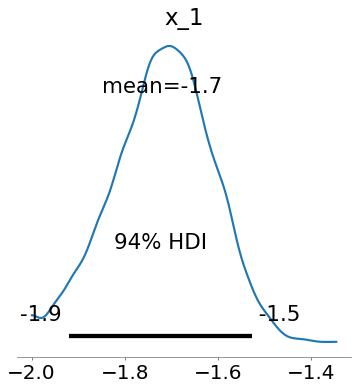

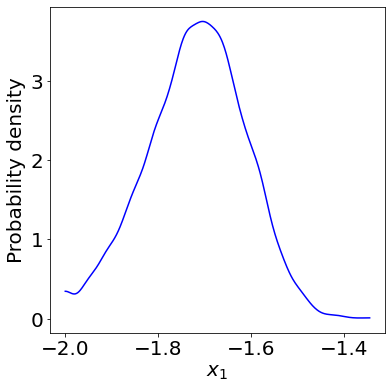

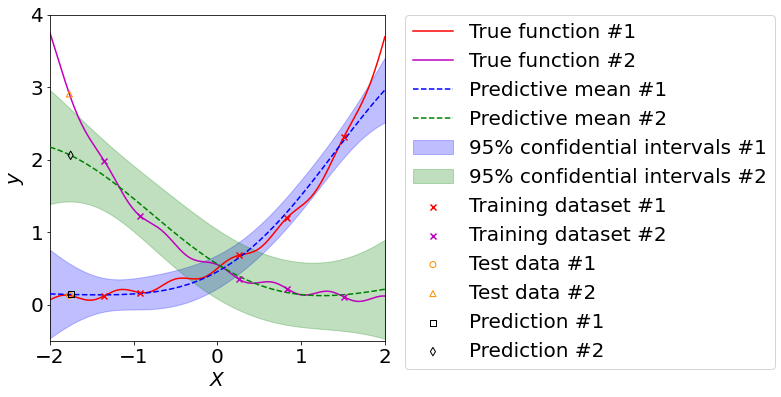

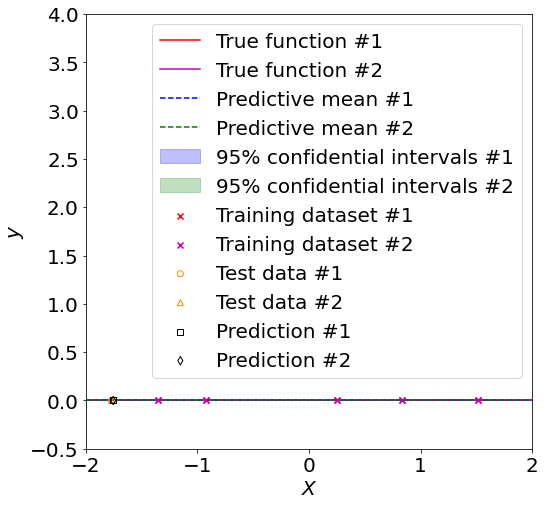

In [ ]:
sigma2 = .1
ls = np.array([l1,l2])
ss = np.array([s1,s2])
sigs = np.array([sig1,sig2])
for i in range(num_sim):
    GPGP = DoJobs(dims, m1,m2,sigma2, i, num_sim,ls,ss,sigs,X_range,Xtr_scaled,Ytr1_scaled,Ytr2_scaled,data1_scaled,data2_scaled)
    GPGP.RunInference()